In [27]:
using Plots

include("src/loader.jl")
include("src/solver.jl")
include("src/simulator.jl")

filename = "profiles.csv";

In [28]:
if ! @isdefined(time_by_week)
    time_by_week, wind_by_week, solar_by_week = load_by_periods(filename, 7 * 24);
end;

In [29]:
# Default values
DEMAND = 1000. # Kg of H2
# CHOSEN CAPACITIES
ELECTRO_CAPA = 1720 * EELEC # MW
TANK_CAPA = 46878 # Kg
BATTERY_CAPA = 600; # MWh
WIND_CAPA = 132 # MW
SOLAR_CAPA = 196; # MW

# Dynamic Programming, simple approach
- We denote by $x^s_t$ the state of the system at time $t$, where $x^s_t$ is the current stock in the tank.
- To remove complexity, we use a discrete state space, where $x^s_t$ take values by e.g. 1/10th of the tank capacity.
- The action at time $t$ is the choice of stock level we want to reach at time $t+1$
- The cost function is given by solving the MILP problem over the period $[t,t+1]$ (e.g usually a week)
- The dynamic programming equation is given by:
$$ V_T(x^s_T) = 0 $$
$$ V_t(x^s_t) = \min_{x^s_{t+1}} \left\{ C(x^s_t,x^s_{t+1}) + V_{t+1}(x^s_{t+1}) \right\} $$
where $C(x^s_t,x^s_{t+1})$ is the cost of reaching $x^s_{t+1}$ from $x^s_t$ over the period $[t,t+1]$ (given by the MILP solver)

## Policy simulator
- We can use the dynamic programming equation to simulate the effect of a given policy
- We compute the operationnal cost over a full year, and compare it to the optimal cost

In [66]:
T = 12 # Weeks (12 periods in time_by_week)
N_STATES = 10 # States in tenth of the tank capacity
states = [(i / N_STATES) * TANK_CAPA for i in 0:N_STATES]

policy = Matrix{Int}(undef, N_STATES + 1, T)
for i in 1:N_STATES + 1
    for j in 1:T
        policy[i, j] = 3
    end
end
policy

11×12 Matrix{Int64}:
 3  3  3  3  3  3  3  3  3  3  3  3
 3  3  3  3  3  3  3  3  3  3  3  3
 3  3  3  3  3  3  3  3  3  3  3  3
 3  3  3  3  3  3  3  3  3  3  3  3
 3  3  3  3  3  3  3  3  3  3  3  3
 3  3  3  3  3  3  3  3  3  3  3  3
 3  3  3  3  3  3  3  3  3  3  3  3
 3  3  3  3  3  3  3  3  3  3  3  3
 3  3  3  3  3  3  3  3  3  3  3  3
 3  3  3  3  3  3  3  3  3  3  3  3
 3  3  3  3  3  3  3  3  3  3  3  3

In [67]:
overall_time = []

for t in 1:T
    append!(overall_time, time_by_week[t])
end

In [68]:
initial_stock_index = 1
initial_stock = states[initial_stock_index]
initial_charge = 0.

output_simulation = simulator(
    T,
    wind_by_week = wind_by_week,
    solar_by_week = solar_by_week,
    states = states,
    policy = policy,
    demand = DEMAND,
    wind_capa = WIND_CAPA,
    solar_capa = SOLAR_CAPA,
    battery_capa = BATTERY_CAPA,
    tank_capa = TANK_CAPA,
    electro_capa = ELECTRO_CAPA,
    initial_stock = initial_stock,
    initial_charge = initial_charge,
);

print("Total cost: $(output_simulation["cost"]) €\n")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25
Total cost: 1.889131555956212e7 €


In [69]:
# Prepare the scatter plot of the production levels constraints
last_hour_by_week = [time_by_week[i][end] for i in 1:T]
# Compute the chain of action to take
action = policy[initial_stock_index, 1]
action_result_by_week = [states[action]]
for t in 2:T
    action = policy[action, t]
    append!(action_result_by_week, states[action])
end

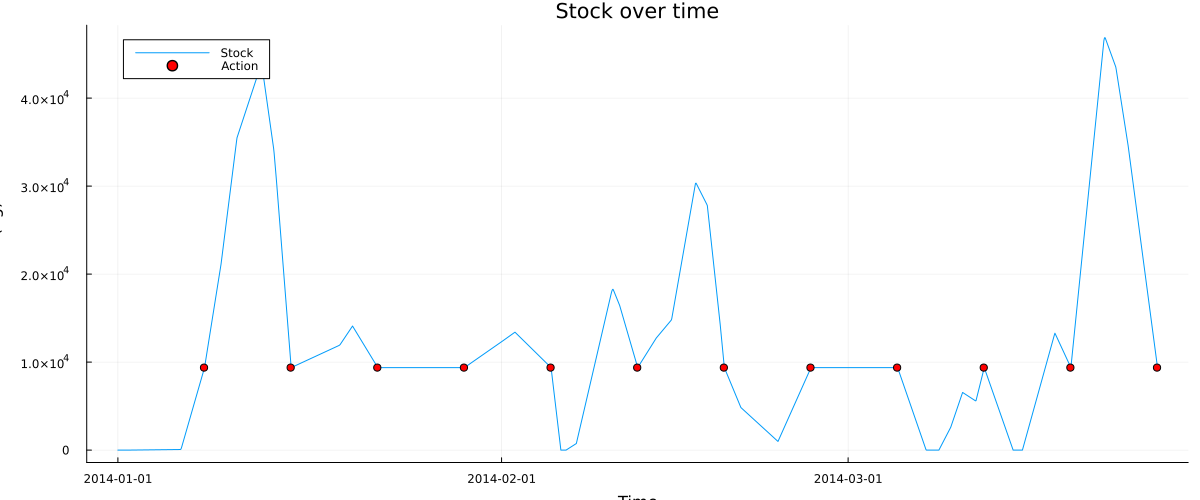

In [70]:
stock_plot = plot(size = (1200, 500), legend = :topleft,
    xlabel = "Time", ylabel = "Stock (Kg)", title = "Stock over time")
plot!(stock_plot, overall_time,
    output_simulation["stock"], label = "Stock") 
scatter!(stock_plot, last_hour_by_week, action_result_by_week, label = "Action", color = :red)

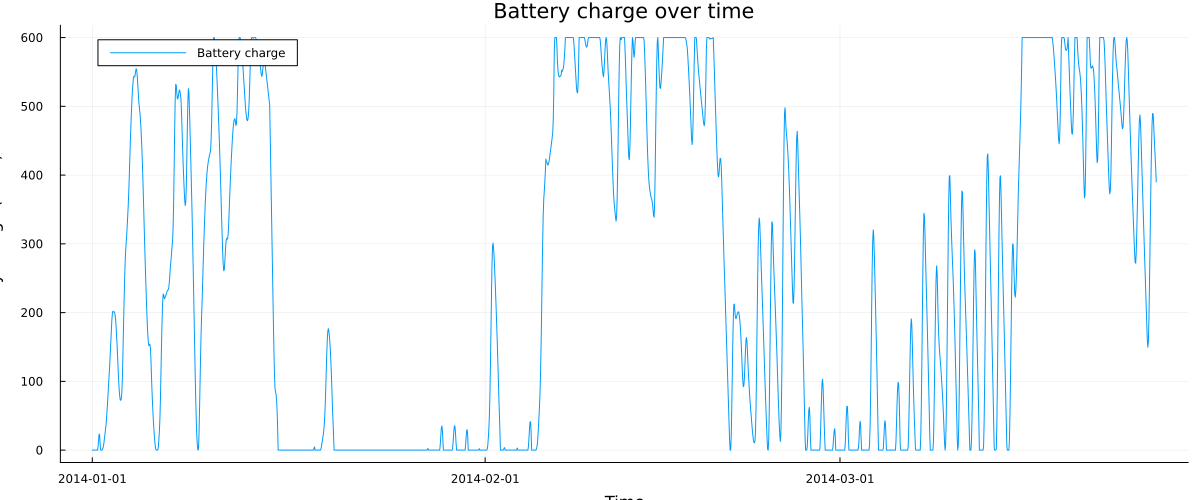

In [71]:
battery_plot = plot(size = (1200, 500), legend = :topleft,
    xlabel = "Time", ylabel = "Battery charge (MWh)", title = "Battery charge over time")
plot!(battery_plot, overall_time, output_simulation["charge"], label = "Battery charge")

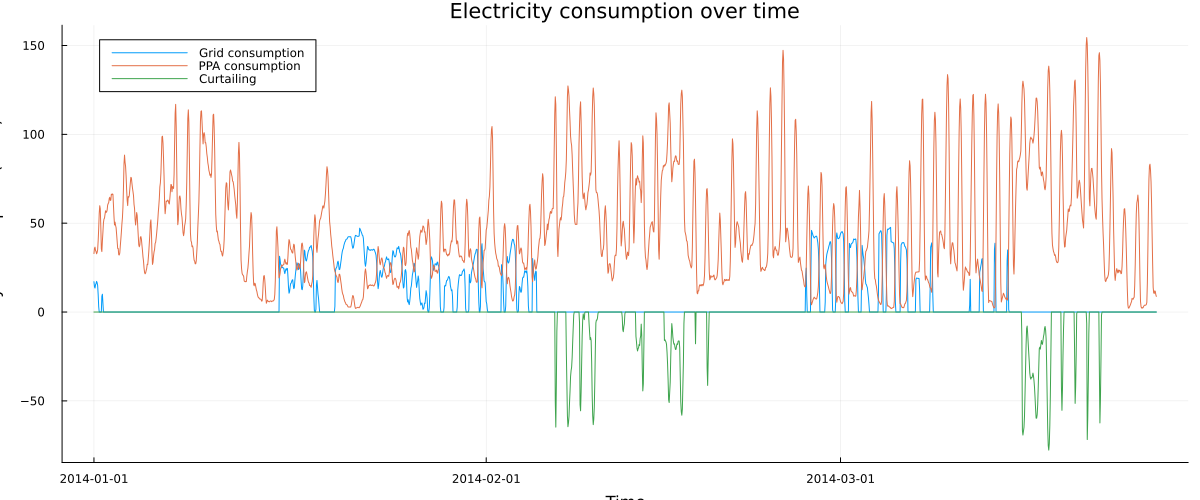

In [72]:
elec_plot = plot(size = (1200, 500), legend = :topleft,
    xlabel = "Time", ylabel = "Electricity consumption (MWh)", title = "Electricity consumption over time")
plot!(elec_plot, overall_time, output_simulation["elec_grid"], label = "Grid consumption")
plot!(elec_plot, overall_time, output_simulation["elec_ppa"], label = "PPA consumption")
plot!(elec_plot, overall_time, -output_simulation["curtailing"], label = "Curtailing")

## Compare with the MILP solution

In [73]:
overall_wind = Vector{Float64}()
overall_solar = Vector{Float64}()
for t in 1:T
    append!(overall_wind, wind_by_week[t])
    append!(overall_solar, solar_by_week[t])
end

In [74]:
output_milp = solve(
    wind_profile = overall_wind,
    solar_profile = overall_solar,
    demand = DEMAND,
    wind_capa = WIND_CAPA,
    solar_capa = SOLAR_CAPA,
    battery_capa = BATTERY_CAPA,
    tank_capa = TANK_CAPA,
    electro_capa = ELECTRO_CAPA,
    initial_charge = initial_charge,
    initial_stock = initial_stock,
    final_charge = -1., # Battery is not constrained at the end
    final_stock = output_simulation["stock"][end],
);

Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-25


In [75]:
policy_cost = output_simulation["cost"]
milp_cost = output_milp["operating_cost"]

print("Policy cost: $(policy_cost) €\n")
print("MILP cost: $(milp_cost) €\n")
print("Optimality gap: $(100 * (policy_cost - milp_cost) / milp_cost) %\n")

Policy cost: 1.889131555956212e7 €
MILP cost: 1.6582049663384037e7 €
Optimality gap: 13.926299480801411 %
